In [1]:
from itertools import chain
import scipy
from scipy.optimize import fmin
from scipy.stats import norm
from scipy.stats import beta
from scipy.special import gamma as gammaf
import numpy as np
import random
import time
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

On découpe aléatoirement un génome en N fragments et on récupère la taille des fragments obtenus.
On cherche à vérifier que la distribution de la taille de ces fragments suit une loi bêta(1,N).

In [5]:
def get_parts(longueur, nbr_frag):
    """
    découpe aléatoirement un génome 
    <longueur>: longueur du génome à découper
    <nbr_frag>: nombre de fragments souhaités
    Return <nll>: liste de taille des fragments obtenus
    """
    cuts = set()
    while len(cuts) < nbr_frag - 1:
        cuts.add(random.randint(1, longueur - 1))
    cuts = [0] + list(sorted(cuts)) + [longueur]
    return [cuts[i + 1] - cuts[i] for i in range(len(cuts) - 1)]

On affiche l'histogramme de la distribution des tailles desfragments. 

Ici on a coupé un génome de taille 1 000 000 en N = 60 000 morceaux.

On affiche également la densité de la loi bêta de paramètres : 1,N

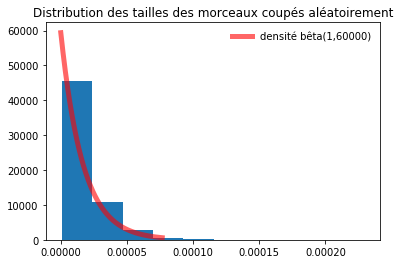

In [11]:
a=1
b=60000

taille = get_parts(1000000, 60000)

t = sum(taille)
taille = [i / t for i in taille] #normalise les tailles pour qu'elles soient comprises entre 0 et 1

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 60000)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(taille)
plt.legend(loc='best', frameon=False)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()

On remarque que la courbe de la densité de la loi bêta(1,60000) a la même allure que la distribution des tailles.

Nous allons ensuite "fitter" cette distribution en utilisant la méthode des moments et celle du maximum de vraisemblance afin d'estimer les paramètres de la loi bêta.



Soit la moyenne empirique : $m$ = $ \frac{1}{n} $$\sum_{i=1}^{n} x_{i}$ 

et la variance : $v$ = $ \frac{1}{n} $$\sum_{i=1}^{n} (x_{i}-m)$

D'après la méthode des moments on estime les paramètres de la loi bêta($\alpha$, $\beta$) 

$\alpha$ = $m$($ \frac{m(1-m)}{v}$$ - 1)$

$\beta$ = $(1-m)$($ \frac{m(1-m)}{v}$$-1)$


In [12]:
mean = np.mean(taille)
var = np.var(taille, ddof=1)

alpha1 = mean ** 2 * (1 - mean) / var - mean
beta1 = alpha1 * (1 - mean) / mean

print("Les paramètres estimés par la méthode des moments sont : alpha = ", alpha1, ", beta = ",beta1)


Les paramètres estimés par la méthode des moments sont : alpha =  1.074911075297147 , beta =  64493.589606753514


 En utilisant la méthode du maximum de vraisemblance : 
 
 $l($$\alpha$, $\beta$$)$ $=$ $\sum_{i=1}^{n} $$-$log$f_{(\alpha, \beta)}(x_{i})$
 
 où $f_{(\alpha, \beta)}$ : la fonction densité de la loi bêta($\alpha$, $\beta$)
 
 L'estimateur du maximum de vraisemblance de $\alpha$ et $\beta$ est donné par :
 
 $(\hat{\alpha}, \hat{\beta})$ = $\underset{\alpha>0, \beta>0 }{argmin}$ $l($$\alpha$, $\beta$$)$
 
 

In [13]:
def betaNLL(param, *args):
    """
    log négative vraisemblance pour bêta
    <param>: liste des paramètres à "fitter"
    <args>: données à "fitter"
    Return <nll>: log négative vraisemblance à minimiser
    """  
    a, b = param
    data = args[0]
    pdf = beta.pdf(data,a,b,loc=0,scale=1)
    lg = np.log(pdf)
    nll = -1*np.sum(lg)
    return nll

In [14]:
result = fmin(betaNLL, [1, 1], args=(taille,))
alpha2, beta2 = result

print("Les paramètres estimés par la méthode de la vraisemblance sont : \nalpha = ", alpha2, ", beta = ",beta2)



Optimization terminated successfully.
         Current function value: -600641.643182
         Iterations: 121
         Function evaluations: 249
Les paramètres estimés par la méthode de la vraisemblance sont : 
alpha =  1.1847209443184674 , beta =  71081.90518272723


On affiche ensuite les densités des lois bêta dont les paramètres ont été trouvés précedemment.

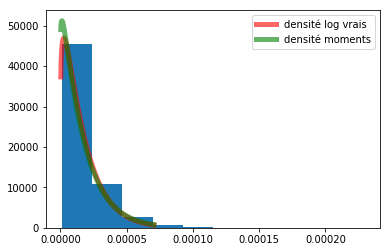

In [15]:
xx = np.linspace(beta.ppf(0.01, alpha2, beta2), beta.ppf(0.99, alpha2, beta2), 60000)
plt.plot(xx, beta.pdf(xx, alpha2, beta2),'r-', lw=5, alpha=0.6, label='densité log vrais')
plt.plot(xx, beta.pdf(xx, alpha1, beta1),'g-', lw=5, alpha=0.6, label='densité moments')
plt.legend()
plt.hist(taille)
plt.show()

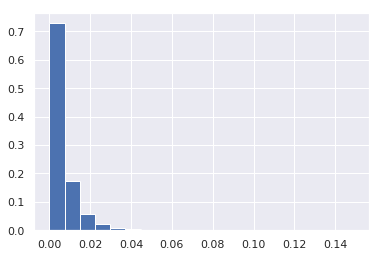

409995


In [21]:
monFichier = open("../Documents/Donnees/DRR164913.fastq", "r")
taille = []
f = []
norm = []

for line in monFichier:
    fields = line.strip().split()
    for idx, word in enumerate(fields):
        f.append(word)

for i, element in enumerate(f):
    if element.endswith("/1") and i + 1 < len(f):
        taille.append(len(f[i + 1]))


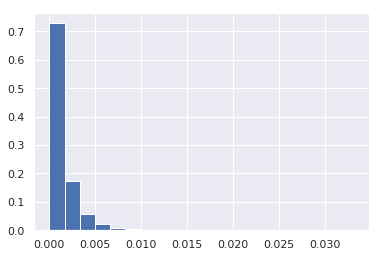

409995


In [26]:
t = 4500000

norm = [i / t for i in taille]
weights = np.ones_like(taille) / float(len(taille))
plt.hist(norm, bins=20, weights=weights)
plt.show()
print(len(taille))

On écrit un programme permettant de découper un génome en N morceaux où N suit soit une loi normale, uniforme, de poisson ou binomiale.

In [127]:

lois = ['normale', 'uniforme', 'poisson', 'binomiale']

def fracture(echantillons, taille_genome, n, sigma=100, loi='normale'):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    #
    échantillons_fracturés = []
    échantillon_fracture = []
    nfrag = dict(
        normale = n + np.random.randn(len(echantillons)) * sigma,
        uniforme = np.random.uniform(0, n*2, len(echantillons)),
        poisson = np.random.poisson(n, len(echantillons)), #erreur
        géométrique = np.random.geometric(1./n, len(echantillons)),#erreur 
        binomiale = np.random.binomial(taille_genome, n/taille_genome, len(echantillons))
        
    )[loi]

    for i in range(len(echantillons)):
        nfrag[i]=nfrag[i]/(nfrag[i]/100)
    
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, nfrag), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
            print(fractures, "n")
        fractures = list[fractures]
        print(fractures)
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        
        #échantillon_fracturé = random.sample(échantillon_fracturé, n)
    
    
    
        échantillons_fracturés.append(échantillon_fracture)
        
      
    return échantillons_fracturés

In [128]:
list = [666, 13766, 47334, 7651, 13131, 4069, 6180, 12103, 68, 10451, 16859, 732, 6465, 778, 15658, 9526, 8295, 22053, 52444, 10826, 6424, 8325, 36972, 3961, 10583, 50487, 183, 2827, 25102, 7928, 74696, 18339, 1313, 451, 34297, 8300, 34447, 12454, 4475, 10851, 2219, 24505, 17641, 3059, 32688, 10582, 123, 25415, 82584, 11956, 10742, 7384, 24993, 4427, 6810, 33696, 12353, 17312, 1393, 5214, 21026, 5218, 34700, 3673, 7501, 4279, 17525, 7428, 12956, 16095, 20983, 595, 25822, 15302, 3007, 4335, 13462, 18109, 4299, 7199, 7809, 20008, 33457, 5098, 19668, 26500, 7232, 3444, 3538, 28793, 9242, 1787, 34993, 15712, 16009, 15977, 682, 20347, 8785, 30839]
print ("choosing 3 random items from a list using sample function",random.sample(list,50))

choosing 3 random items from a list using sample function [5214, 8325, 4475, 778, 7232, 595, 24993, 123, 18339, 21026, 34297, 9526, 20983, 8300, 12956, 3059, 6465, 18109, 33457, 7651, 7809, 3538, 10851, 4427, 30839, 12454, 3673, 666, 6810, 6180, 13131, 8295, 16095, 732, 20347, 10582, 3961, 16009, 7428, 10583, 82584, 1787, 16859, 15658, 2219, 22053, 36972, 9242, 183, 1313]


In [129]:
sns.set(color_codes=True)
# sns.distplot(fragments, kde=False, rug=False)
# plt.show()

taille_genome =1500000
nombre_morceaux = 409995
seuil = 80000

for loi in lois:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, taille_genome, nombre_morceaux, loi=loi)))
    #fragments = [x for x in fragments if x < seuil] 
    print(fragments)
    weights = np.ones_like(fragments) / float(len(fragments))
    print(len(fragments))
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    plt.hist(fragments, bins=20, weights=weights)
    plt.show()



TypeError: list indices must be integers or slices, not set

On calcule la densité de la loi composée H de la loi bêta F et de poisson G.

$p_{H}(x) = \int_{0}^{+\infty} p_{F}(x|\theta) p_{G}(\theta)d\theta$

$p_{H}(x) = \int_{0}^{+\infty}n(1-x)^{n-1}\frac{\lambda^{n}e^{-\lambda}}{n!}dn$


[0.00000000e+00 8.16326531e-06 1.63265306e-05 2.44897959e-05
 3.26530612e-05 4.08163265e-05 4.89795918e-05 5.71428571e-05
 6.53061224e-05 7.34693878e-05 8.16326531e-05 8.97959184e-05
 9.79591837e-05 1.06122449e-04 1.14285714e-04 1.22448980e-04
 1.30612245e-04 1.38775510e-04 1.46938776e-04 1.55102041e-04
 1.63265306e-04 1.71428571e-04 1.79591837e-04 1.87755102e-04
 1.95918367e-04 2.04081633e-04 2.12244898e-04 2.20408163e-04
 2.28571429e-04 2.36734694e-04 2.44897959e-04 2.53061224e-04
 2.61224490e-04 2.69387755e-04 2.77551020e-04 2.85714286e-04
 2.93877551e-04 3.02040816e-04 3.10204082e-04 3.18367347e-04
 3.26530612e-04 3.34693878e-04 3.42857143e-04 3.51020408e-04
 3.59183673e-04 3.67346939e-04 3.75510204e-04 3.83673469e-04
 3.91836735e-04 4.00000000e-04]


/home/aghoul/venv/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/aghoul/venv/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


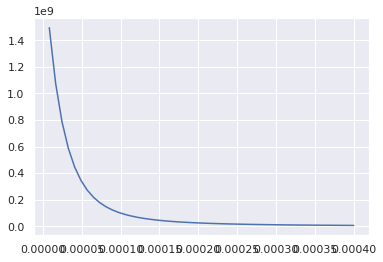

In [65]:
from math import exp, log
sns.set(color_codes=True)
x=np.linspace(0,0.0004)
print(x)
b=65000

plt.plot(x, b*np.exp(b*np.log(1-x))/np.log(1-x)-(1/(np.log(1-x))**2)*(np.exp(b*np.log(1-x))-1))
plt.show()